<a href="https://colab.research.google.com/github/gabrie1-s/cnn-1d/blob/test/test_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
from pathlib import Path
import scipy.io
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pandas as pd
from sklearn.preprocessing import normalize, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Aquisição dos Dados

In [4]:
data = Path('drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/data')

signals = []
classes =[]

for value in sorted(data.glob('*.mat')):
  signal = scipy.io.loadmat(value)
  signal = np.array(signal["val"], dtype='float')[0]
  signals.append(signal)
  # print(value)
  
classification_path = os.path.join(data, "classification.txt")
with open(classification_path) as f:
    classes = f.readlines()

for i in range(0, len(classes)):
  classes[i] = classes[i][classes[i].find(','):]
  classes[i] = classes[i][: classes[i].find('\n')]
  classes[i] = classes[i].replace(",", "")

# 2. Preprocessamento

### 2.1 Análise da distribuição das classes

In [5]:
d = {'signals': signals, 'classes': classes}
df = pd.DataFrame(data=d)
a = df.groupby('classes')
for i in ['N', 'O', 'A', '~']:
  print(i)
  aux = []

  for j in a.get_group(i)["signals"]:
    aux.append(len(j))

  print('Média:', round(np.mean(aux), 2))
  print("Std:", round(np.std(aux), 2))
  print("Qntd:", len(aux))
  print("Min:", min(aux))
  print("---------------")

N
Média: 9633.38
Std: 2991.84
Qntd: 5076
Min: 2714
---------------
O
Média: 10288.52
Std: 3528.74
Qntd: 2415
Min: 2738
---------------
A
Média: 9703.41
Std: 3694.64
Qntd: 758
Min: 2996
---------------
~
Média: 7313.63
Std: 3122.42
Qntd: 279
Min: 2808
---------------


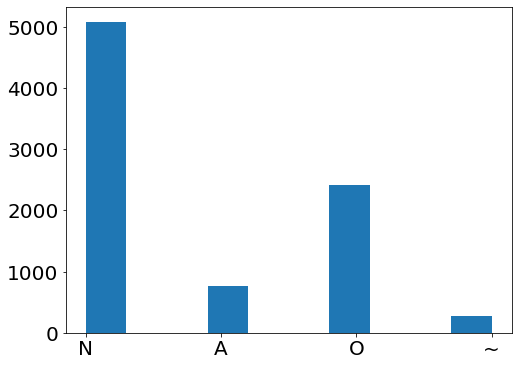

In [6]:
plt.rcParams.update({'font.size': 20})

df["classes"].hist(
    figsize=(8, 6),
    grid = False,
    bins = 10,
)
plt.xticks(range(4))
plt.show()

### 2.2 Wavelet helping functions

In [7]:
def gera_filtro_MH(Escala):
  passo = 1/Escala
  X = []
  a = -5
  X.append(a)
  while a <= 5:
    a=a+passo
    X.append(a)
  Y = []
  for i in range(0,len(X)):
    Y.append(2.1741*(1/math.sqrt(2*math.pi) * (1 - X[i]**2) * np.exp(-X[i]**2/(2))))
  return Y

def apply_wavelet(signal, level):
  Filtro = gera_filtro_MH(level)
  y = np.convolve(signal,Filtro)
  return y

### 2.3 Aplicação da tranformada Wavelet

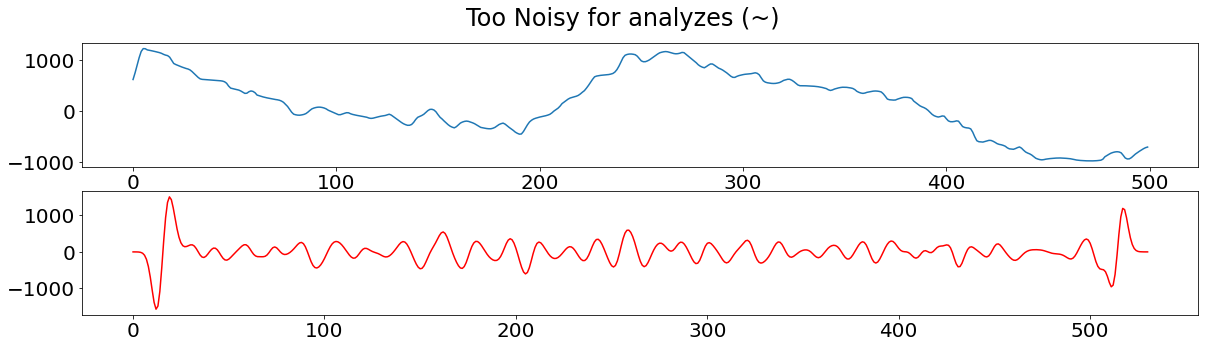

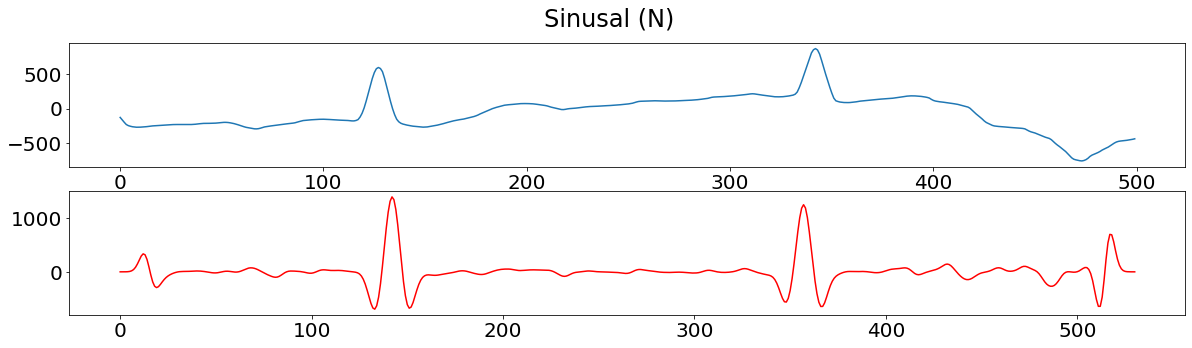

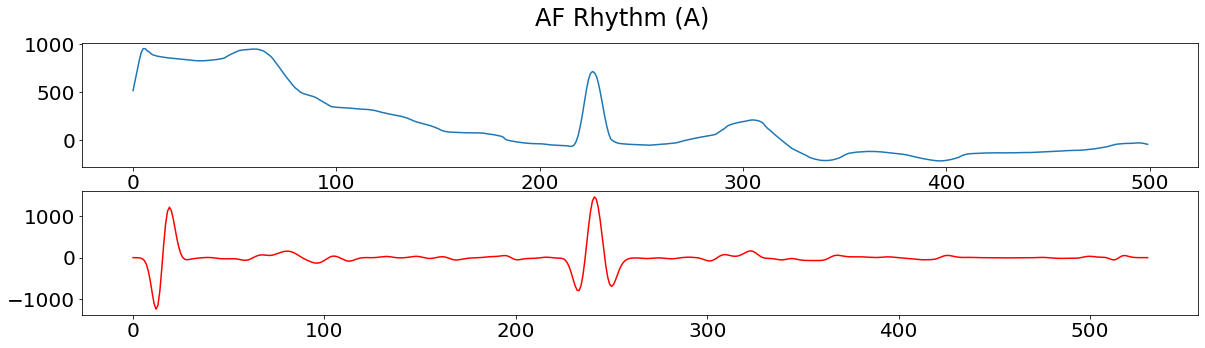

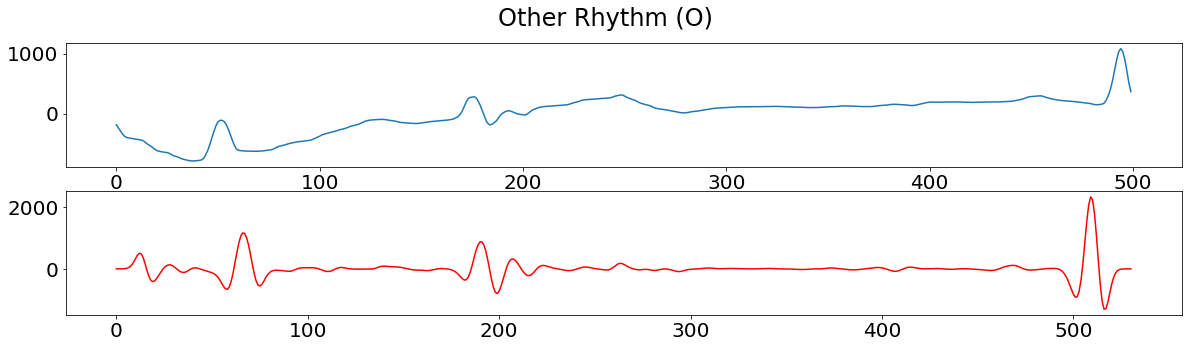

In [8]:
plt.rcParams['figure.figsize']=(20,5)

signal = df[df["classes"] == '~'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("Too Noisy for analyzes (~)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

signal = df[df["classes"] == 'N'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("Sinusal (N)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

signal = df[df["classes"] == 'A'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("AF Rhythm (A)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

signal = df[df["classes"] == 'O'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("Other Rhythm (O)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()


In [9]:
x = []
for i in signals:
  val = apply_wavelet(i, 3)
  x.append(val)

### 2.4 Janelamento dos dados de treino

In [10]:
intersection = 100
window_size = 500
windows_array = ["max","max","max","max"]
classes_array = ['N', 'O', 'A', '~']

In [11]:
def window(signal, intersection, window_size, n):
  s_size = len(signal)
  max_n = (s_size-intersection)/(window_size - intersection)
  samples = []
  
  if  n == "max" or n > max_n:
    n = max_n
    n = math.floor(n)
    
  max_begin = s_size - (n*(window_size) - (n-1)*intersection)
  init = random.randrange(max_begin)
  for i in range(0, n):
    begin = init + i*window_size - i*intersection
    end = begin + window_size
    samples.append(signal[begin:end])

  
  return samples

In [12]:
def embalance_data(df, classes_array, windows_array, intersection, window_size):

  a = df.groupby('classes')
  d_train = df.copy()
  d_train = d_train.iloc[0:0]


  idx = -1
  for i in classes_array:

    idx += 1

    for index, row in a.get_group(i).iterrows():
      samples = window(row["signals"], intersection, window_size,  windows_array[idx])
      
      for k in range(len(samples)):
        d_train = d_train.append({'signals': samples[k], 'classes': i}, ignore_index=True)

  return d_train

In [13]:
x_rem, x_test, y_rem, y_test = train_test_split(x, df["classes"], test_size=0.25)
x_train, x_valid, y_train, y_valid = train_test_split(x_rem, y_rem, test_size=0.1)

d_aux = pd.DataFrame({'signals': x_train, 'classes': y_train})
d_train = embalance_data(d_aux, classes_array, windows_array, intersection, window_size)

d_aux = pd.DataFrame({'signals': x_valid, 'classes': y_valid})
d_valid = embalance_data(d_aux, classes_array, windows_array, intersection, window_size)

b = d_train.groupby('classes')

for i in ['N','O', 'A', '~']:
  print(i)
  aux = []

  for j in b.get_group(i)["signals"]:
    aux.append(len(j))

  print('Média:', round(np.mean(aux), 2))
  print("Std:", round(np.std(aux), 2))
  print("Qntd:", len(aux))
  print("Min:", min(aux))
  print("---------------")

N
Média: 500.0
Std: 0.0
Qntd: 81369
Min: 500
---------------
O
Média: 500.0
Std: 0.0
Qntd: 40882
Min: 500
---------------
A
Média: 500.0
Std: 0.0
Qntd: 11638
Min: 500
---------------
~
Média: 500.0
Std: 0.0
Qntd: 3200
Min: 500
---------------


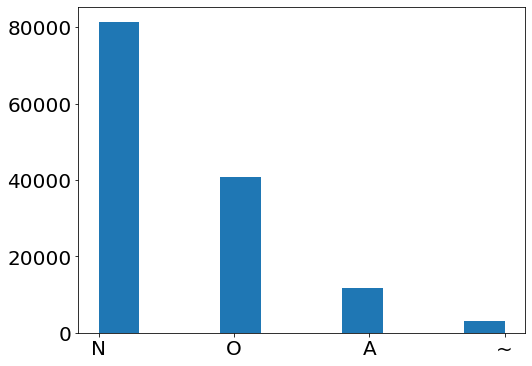

In [14]:
plt.rcParams.update({'font.size': 20})

d_train["classes"].hist(
    figsize=(8, 6),
    grid = False,
    bins = 10,
)
plt.xticks(range(4))
plt.show()

In [15]:
d_train = d_train.sample(frac=1, random_state=1)
signals_2 = d_train["signals"]
classes_2 = d_train["classes"]

### 2.4 "Normalização" do tamanho dos sinais

In [16]:
# for i in range(0, len(x)):
#   val = normalize([x[i]])
#   x[i] = val[0]
# 3. Implementação da CNN

# 3. Implementação do modelo

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl

In [18]:
y_train = classes_2
x_train = list(signals_2)
x_train = np.array(x_train)

x_valid = np.array(list(d_valid["signals"]))
y_valid = d_valid["classes"]
x_test = np.array(x_test)

<ipython-input-18-87e52f2cfeb0>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test = np.array(x_test)


In [19]:
# x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
# # x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
# x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], 1)

In [20]:
# Import packages
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import classification_report 


pd.set_option("display.max_columns", None)

from sklearn import metrics
import tensorflow as tf

In [21]:
score_acc = make_scorer(accuracy_score)

In [42]:
def create_cnn(x_train, y_train, x_valid, y_valid):
  
  #x_train = np.array(list(x_train))
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
  y_train = pd.get_dummies(y_train)

  x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], 1)
  y_valid = pd.get_dummies(y_valid)

  print(y_train.columns)

  input_shape = len(x_train[0])
  k1 = 5
  k2 = 3
  n = math.floor(input_shape/(k1+k2-2))
  nn_input = input_shape % (k1+k2-2)

  classificador = Sequential()

  for i  in range(0, 5):
    if i == 0:
      classificador.add(Conv1D(filters=32, kernel_size = k1, input_shape = (input_shape, 1), activation = "relu"))
    else:
        classificador.add(Conv1D(filters=32, kernel_size = k1, activation = "relu"))
    
    classificador.add(Conv1D(filters=64, kernel_size = k2, activation = "relu"))
    classificador.add(MaxPooling1D(pool_size=2))

  classificador.add(Flatten())

  classificador.add(Dense(units=64, activation='relu'))
  classificador.add(Dense(units=32, activation='relu'))
  classificador.add(Dense(units=16, activation='relu'))

  classificador.add(Dense(2, activation="softmax"))

  classificador.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate=0.01), metrics=["accuracy"])


  es = EarlyStopping(monitor="accuracy", mode='max', verbose=0, patience=15)
  history = classificador.fit(x_train, y_train, epochs=150, batch_size=128, validation_data = (x_valid, y_valid), callbacks=es, verbose=1)
  
  return y_train.columns, classificador, history

# 4. Implementação da árvore

In [43]:
# x_train = x_train[0:200]
# y_train = y_train[0:200]

In [44]:
class RootNode:
  def __init__(self):
    self.child = None

In [45]:
class BinaryTreeNode:
  def __init__(self, model, classe):
    self.columns = None
    self.classe = classe
    self.model = model
    self.leftChild = None
    self.rightChild=None

In [46]:
def print_history(history, classe, classificador, x_valid, y_valid, columns):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy '+classe)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('plot '+classe+'.png')
    plt.show()

    y_pred = classificador.predict(x_valid)
    y_pred = pd.DataFrame(y_pred)
    y_pred.columns = columns

    y_pred = y_pred.idxmax(axis=1)
    relatorio = classification_report(y_valid, y_pred) 
    print(relatorio)

In [47]:
def build_tree(x_train, y_train, x_valid, y_valid, classes_array, father):  

  if len(classes_array) < 2:
    print("impossivel classificar")
    return

  minority = classes_array[0]
  del classes_array[0]

  if len(classes_array) != 1:
    y_next = y_train.replace(classes_array, "nan")
    y_next_val = y_valid.replace(classes_array, "nan")
  else:
    y_next = y_train
    y_next_val = y_valid

  columns, model, history = create_cnn(x_train, y_next, x_valid, y_next_val)
  node = BinaryTreeNode(model=model, classe="nan")
  node.leftChild = BinaryTreeNode(model=None, classe=minority)
  node.columns = columns

  print_history(history, minority, model, x_valid, y_next_val, columns)

  if type(father) == RootNode:
    father.child = node
  else:
    father.rightChild = node

  if len(classes_array) == 1:
    node.rightChild = BinaryTreeNode(model=None, classe=classes_array[0])
  else:
    aux_df = pd.DataFrame({"signals": list(x_train), "classes": y_train})
    aux_df_valid = pd.DataFrame({"signals": list(x_valid), "classes": y_valid})

    aux_df.drop(aux_df[aux_df['classes'] == minority].index, inplace=True)
    aux_df_valid.drop(aux_df_valid[aux_df_valid['classes'] == minority].index, inplace=True)

    x_next = np.array(list(aux_df["signals"]))
    x_next_val = np.array(list(aux_df_valid["signals"]))

    y_next = aux_df["classes"]
    y_next_val = aux_df_valid["classes"]
    
    build_tree(x_next, y_next, x_next_val, y_next_val, classes_array, node) 


Index(['A', 'nan'], dtype='object')
Epoch 1/150
1072/1072 [==============================] - 17s 15ms/step - loss: 0.2968 - accuracy: 0.9155 - val_loss: 0.2041 - val_accuracy: 0.9206
Epoch 2/150
1072/1072 [==============================] - 15s 14ms/step - loss: 0.2124 - accuracy: 0.9206 - val_loss: 0.2017 - val_accuracy: 0.9243
Epoch 3/150
1072/1072 [==============================] - 15s 14ms/step - loss: 0.2052 - accuracy: 0.9221 - val_loss: 0.1912 - val_accuracy: 0.9244
Epoch 4/150
1072/1072 [==============================] - 16s 14ms/step - loss: 0.2010 - accuracy: 0.9232 - val_loss: 0.1802 - val_accuracy: 0.9324
Epoch 5/150
1072/1072 [==============================] - 15s 14ms/step - loss: 0.1952 - accuracy: 0.9242 - val_loss: 0.1950 - val_accuracy: 0.9275
Epoch 6/150
1072/1072 [==============================] - 15s 14ms/step - loss: 0.1925 - accuracy: 0.9258 - val_loss: 0.1858 - val_accuracy: 0.9295
Epoch 7/150
1072/1072 [==============================] - 15s 14ms/step - loss: 0.1

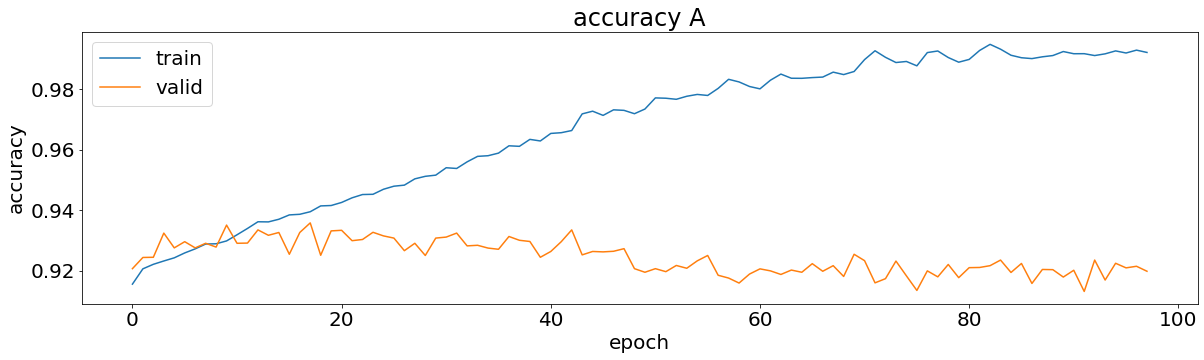

473/473 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           A       0.52      0.51      0.52      1274
         nan       0.96      0.96      0.96     13854

    accuracy                           0.92     15128
   macro avg       0.74      0.73      0.74     15128
weighted avg       0.92      0.92      0.92     15128

Index(['O', 'nan'], dtype='object')
Epoch 1/150
981/981 [==============================] - 15s 14ms/step - loss: 0.5960 - accuracy: 0.7070 - val_loss: 0.5871 - val_accuracy: 0.7072
Epoch 2/150
981/981 [==============================] - 14s 14ms/step - loss: 0.5676 - accuracy: 0.7280 - val_loss: 0.5732 - val_accuracy: 0.7207
Epoch 3/150
981/981 [==============================] - 14s 14ms/step - loss: 0.5475 - accuracy: 0.7427 - val_loss: 0.5579 - val_accuracy: 0.7233
Epoch 4/150
981/981 [==============================] - 14s 14ms/step - loss: 0.5306 - accuracy: 0.7544 - val_loss: 0.5355 - val_accuracy: 0.7518
Ep

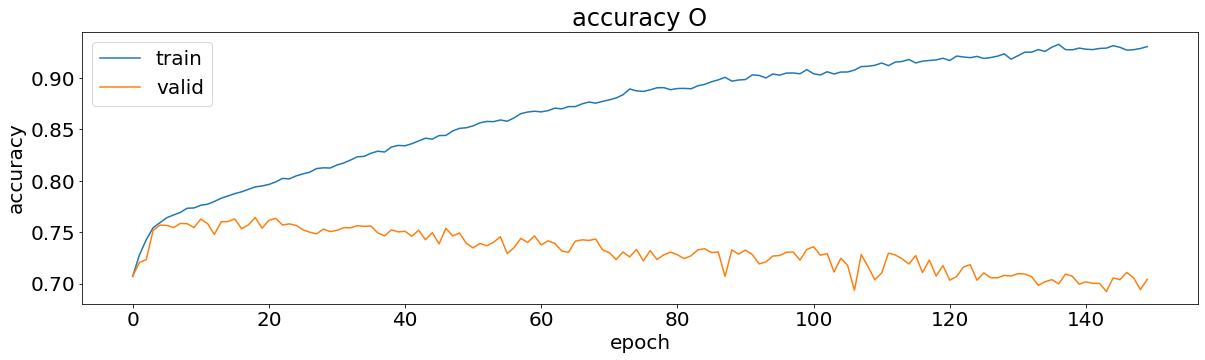

433/433 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           O       0.58      0.56      0.57      4801
         nan       0.77      0.78      0.78      9053

    accuracy                           0.70     13854
   macro avg       0.67      0.67      0.67     13854
weighted avg       0.70      0.70      0.70     13854

Index(['N', '~'], dtype='object')
Epoch 1/150
661/661 [==============================] - 11s 15ms/step - loss: 0.1834 - accuracy: 0.9630 - val_loss: 0.1396 - val_accuracy: 0.9459
Epoch 2/150
661/661 [==============================] - 9s 14ms/step - loss: 0.1072 - accuracy: 0.9646 - val_loss: 0.1353 - val_accuracy: 0.9525
Epoch 3/150
661/661 [==============================] - 10s 14ms/step - loss: 0.1027 - accuracy: 0.9662 - val_loss: 0.1633 - val_accuracy: 0.9472
Epoch 4/150
661/661 [==============================] - 9s 14ms/step - loss: 0.1016 - accuracy: 0.9663 - val_loss: 0.1345 - val_accuracy: 0.9545
Epoch 

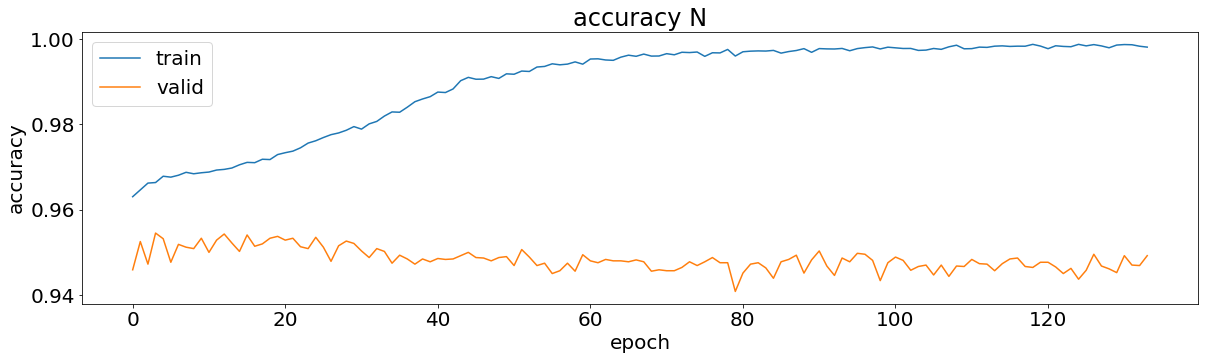

283/283 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           N       0.96      0.99      0.97      8525
           ~       0.63      0.32      0.42       528

    accuracy                           0.95      9053
   macro avg       0.79      0.65      0.70      9053
weighted avg       0.94      0.95      0.94      9053



In [48]:
classes_array = ['A', 'O', 'N', '~']
# [classes_array.append(item) for item in y_train if item not in classes_array]
root = RootNode()
build_tree(x_train, y_train,x_valid, y_valid, classes_array, root)

In [49]:
def make_prediction(current_node, samples):
    if type(current_node) == RootNode:
        current_node = current_node.child

    samples = window(signal, intersection, window_size, "max")
    samples = np.array(samples)
    samples = samples.reshape(samples.shape[0],samples.shape[1], 1)

    while current_node.model != None:
        model = current_node.model
        prediction = model.predict(samples)
        prediction = pd.DataFrame(prediction)
        prediction.columns = current_node.columns
        prediction = prediction.idxmax(axis=1)
        prediction = prediction.mode()[0]
        # print(prediction)

        if prediction == current_node.leftChild.classe:
            current_node = current_node.leftChild
        elif prediction == current_node.rightChild.classe:
            current_node = current_node.rightChild

    return current_node.classe

In [50]:
y_pred = []
for signal in x_test:
    prediction = make_prediction(root, signal)
    y_pred.append(prediction)

A saída de streaming foi truncada nas últimas 5000 linhas.
1/1 [==============================] - 0s 23ms/step


In [51]:
classes_list = []
for i in y_test:
    if i not in classes_list:
        classes_list.append(i)

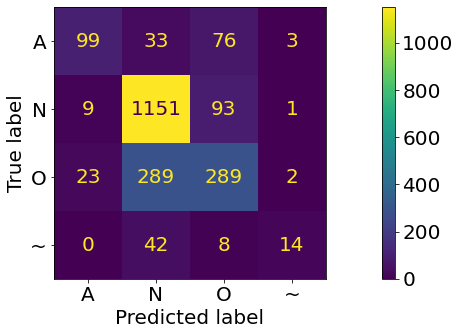

In [52]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

cf_matrix = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = classes_list)
cm_display.plot()
plt.savefig("test.png")

In [53]:
acc = accuracy_score(y_test, y_pred)

print("matriz de confusão:", cf_matrix)
print("labels:", classes_list)
print("acurácia:", acc)

matriz de confusão: [[  99   33   76    3]
 [   9 1151   93    1]
 [  23  289  289    2]
 [   0   42    8   14]]
labels: ['A', 'N', 'O', '~']
acurácia: 0.7284240150093808
